In [1]:
# Importing modules
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
from astropy.cosmology import Planck13
cosmo=Planck13
from astropy . coordinates import Distance
from astropy import units as u
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import random
import matplotlib
import os

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [4]:
# Importing GAMA galaxies for zmax measurements
hdul = fits.open('../GAMA_supplementation/G3CGalv10.fits')
data = hdul[1].data
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_gals=t[names].to_pandas()
df_gals=df_gals.set_index('CATAID')

In [5]:
# Luminosity distance, k correction and absolute magnitude calculations

h=cosmo.H0.value/100
a = [0.2085, 1.0226, 0.5237, 3.5902, 2.3843]
zref = 0
Q0 = 1.75
zp = 0.2


def kcorr(z):
    k=0
    for i in range(len(a)):
        k+= (a[i] * (z - zp)**i)

    return k - (Q0 * (z-zref))

df_gals['LumDistance'] = cosmo.luminosity_distance(np.array(df_gals['Z'])).value  * h * 1e6
df_gals['Kcorr'] = df_gals['Z'].apply(kcorr)
df_gals['AbMag'] = df_gals['Rpetro']-5*np.log10(df_gals['LumDistance'])+5 - df_gals['Kcorr']

In [6]:
# Importing groups, with supplemented masses
dfHalo=pd.read_csv('../data/GAMA_groups.csv')

dfHalo=dfHalo.set_index('GroupID')

dfHalo['Z']=dfHalo['IterCenZ']
dfHalo['RA']=dfHalo['IterCenRA']
dfHalo['Dec']=dfHalo['IterCenDec']

In [9]:
# Establishing the error on dyanmical mass, as this will become important for HMF later
# Equation 20 of Robotham et al 2011

dfHalo['Merr']=np.nan

dfHalo.loc[dfHalo[dfHalo['Nfof']<=50].index,'Merr']=(1.39*dfHalo[dfHalo['Nfof']<=50]['MassA']*
                                                     (1-(0.43*np.log10(dfHalo[dfHalo['Nfof']<=50]['Nfof']))))
dfHalo.loc[dfHalo[dfHalo['Nfof']>50].index,'Merr']=0.27*1.39*dfHalo[dfHalo['Nfof']>50]['MassA']

In [7]:
# Removing G02 region
dfHalo=dfHalo[(dfHalo['RA']>100)]
df_gals=df_gals[(df_gals['RA']>100)]

In [8]:
hdul = fits.open('../GAMA_supplementation/StellarMassesv19.fits')
data = hdul[1].data
t=Table(data)
names = [name for name in t.colnames if len(t[name].shape) <= 1]
df_stellar=t[names].to_pandas()

df_stellar=df_stellar.set_index('CATAID')

intersect=np.intersect1d(df_stellar.index,df_gals.index)

df_gals['zmax19p8']=np.NAN
df_gals.loc[intersect,'zmax19p8']=df_stellar.loc[intersect]['zmax_19p8']

/tmp/ipykernel_7604/3569280409.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_gals.loc[intersect,'zmax19p8']=df_stellar.loc[intersect]['zmax_19p8']


In [10]:
sample=dfHalo[(dfHalo['Nfof']>4) & (dfHalo['Z']<0.25)]

In [11]:
# Appending the zmax values to groups according to their fifth brightest galaxy
fifth_brightest=[]

for halo in tqdm(sample.index):
    gals=df_gals[df_gals['GroupID']==halo]
    gals=gals.sort_values(by=['AbMag'])
    fifth_brightest.append(gals.iloc[[4]].index[0])
    
sample['fifth_brightest']=fifth_brightest
sample['zmax19p8']=df_gals.loc[sample['fifth_brightest']]['zmax19p8'].values

  0%|          | 0/1741 [00:00<?, ?it/s]

/tmp/ipykernel_7604/973481751.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['fifth_brightest']=fifth_brightest
/tmp/ipykernel_7604/973481751.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['zmax19p8']=df_gals.loc[sample['fifth_brightest']]['zmax19p8'].values


In [12]:
# If the halo redshift is greater than zmax19p8, then zmax is set to z
sample.loc[sample[sample['Z']>sample['zmax19p8']].index,'zmax19p8']=sample[sample['Z']>sample['zmax19p8']]['Z']

# Setting the upper limit of zmax to 0.25
sample.loc[sample[sample['zmax19p8']>0.25].index,'zmax19p8']=0.25

sample=sample[(sample['zmax19p8']>0)]

In [13]:
# Converting zmax to Vmax
survey_steradian=(60*3)*(np.pi/180)**2
sample['Vmax']=((cosmo.comoving_distance(sample['zmax19p8'].values)**3*h)*(survey_steradian/3)).value

In [15]:
# Calculating HMF with mean of mass_sup and dynamical mass

bins = np.linspace(11.2,15.4,22)

Nbin, edges = np.histogram(((np.log10(sample['mass_sup']) + np.log10(1.39*sample['MassA']))/2), bins=bins)
diff=np.diff(edges)[0]
phi_total_lum, edges = np.histogram(((np.log10(sample['mass_sup']) + np.log10(1.39*sample['MassA']))/2), bins=bins, weights=1.0/(diff*sample['Vmax']))
Mbin = edges[:-1] + np.diff(edges)
phi_err_poisson = phi_total_lum/Nbin**0.5

/tmp/ipykernel_7604/1064838349.py:9: RuntimeWarning: invalid value encountered in true_divide
  phi_err_poisson = phi_total_lum/Nbin**0.5


In [16]:
def MRP(M, M_star, phi_star, alpha, beta):
    return np.log(10) * phi_star * beta * (M/M_star)**(alpha+1) * np.exp(-(M/M_star)**beta)

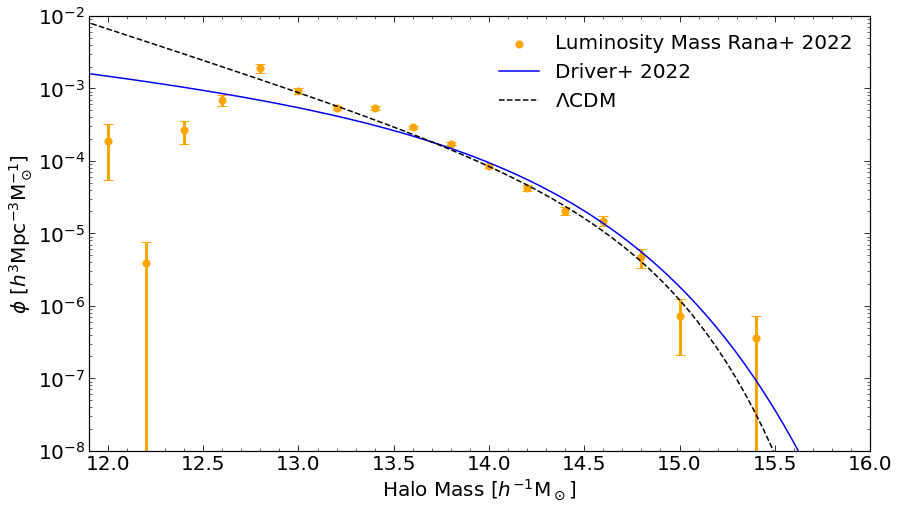

In [17]:
plt.figure(figsize=(14,8))



plt.errorbar(Mbin,phi_total_lum,yerr=phi_err_poisson,
             fmt='none',capsize=5,mfc='none',c='orange',linewidth=3)
plt.scatter(Mbin,phi_total_lum,c='orange',s=50,label='Luminosity Mass Rana+ 2022')



M_arr=np.logspace(11,16,100)
plt.plot(np.log10(M_arr),(MRP(M_arr,10**13.51,10**-3.19,-1.27,0.47)),c='blue',label='Driver+ 2022')
plt.plot(np.log10(M_arr),(MRP(M_arr,10**14.43,10**-4.49,-1.85,0.77)),c='k',linestyle='dashed',label=r'$\Lambda$'+'CDM')
plt.yscale('log')


plt.legend(frameon=False)

plt.xlim(11.9,16)
plt.ylim(1e-8,1e-2)
plt.xlabel('Halo Mass ['+r'$h^{-1}\mathrm{M}_\odot$]')
plt.ylabel(r'$\phi$' +' ['+r'$h^{3}\mathrm{Mpc}^{-3}\mathrm{M}^{-1}_\odot$]')


plt.yscale('log')

In [18]:
# Creating a function that takes 1000 samples from the luminosity-mass scaling relation and dynamical mass

def massconv_sample(halo):
    lum=dfHalo.loc[halo]['lum_sup']
    
    dyn_mass=1.39*dfHalo.loc[halo]['MassA']
    dyn_mass_err=dfHalo.loc[halo]['Merr']
    
    lum_mass_sample =  1e14 * h**-1 * np.random.normal(0.81,0.04,1000) * (lum/(10**11.5 ))**np.random.normal(1.01,0.07,1000)
    
    dyn_mass_sample = np.random.normal(dyn_mass,dyn_mass_err,1000)
    
    tot_mass = 10**((np.log10(lum_mass_sample) + np.log10(dyn_mass_sample))/2)
    
    return tot_mass

In [19]:
# These samples are inputted into a dataframe, where each group is given 1000 independent mass estimates
dfHalo_sample=pd.DataFrame(columns=np.linspace(0,999,1000).astype(int), index=sample.index)

In [20]:
for halo in tqdm(sample.index):
    dfHalo_sample.loc[halo]=(massconv_sample(halo).astype(float))

  0%|          | 0/1741 [00:00<?, ?it/s]

/tmp/ipykernel_7604/3076314818.py:13: RuntimeWarning: invalid value encountered in log10
  tot_mass = 10**((np.log10(lum_mass_sample) + np.log10(dyn_mass_sample))/2)
/tmp/ipykernel_7604/3076314818.py:13: RuntimeWarning: divide by zero encountered in log10
  tot_mass = 10**((np.log10(lum_mass_sample) + np.log10(dyn_mass_sample))/2)


In [21]:
phi_sample=[]

In [22]:
# Calculating the HMF for each sample
for i in tqdm(range(1000)):
    Nbin, edges = np.histogram(np.log10(dfHalo_sample.loc[sample.index][i].astype(float)), bins=bins)
    diff=np.diff(edges)[0]
    phi_total_lum_sample, edges = np.histogram(np.log10(dfHalo_sample.loc[sample.index][i].astype(float)), bins=bins, weights=1.0/(diff*sample['Vmax']))
    phi_sample.append(phi_total_lum_sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
phi_sample[0]

array([0.00000000e+00, 5.11170180e-05, 0.00000000e+00, 2.22299849e-04,
       2.01842564e-05, 1.32526191e-04, 9.14129801e-04, 1.59471552e-03,
       9.51166431e-04, 6.28747641e-04, 3.64319356e-04, 2.63957983e-04,
       1.51378104e-04, 8.71554321e-05, 4.66392335e-05, 1.95355846e-05,
       1.54457418e-05, 3.59203297e-06, 1.09183963e-06, 3.59203297e-07,
       3.59203297e-07])

In [33]:
# Averaging and calculating standard deviation over the 1000 HMFs
means=[]
err=[]
for i in range(len(phi_sample[0])):
    means.append(np.mean(np.stack(phi_sample,axis=0)[:,i]))
    err.append(np.std(np.stack(phi_sample,axis=0)[:,i]))
means=np.array(means)
err=np.array(err)

In [34]:
# Calcuating the total HMF error as the MCMC error, poisson error and cosmic variance (0.07) error in quadrature
err_tot=np.sqrt(err**2 + phi_err_poisson**2 + (0.07*means)**2)

In [35]:
# The overall HMF as phi_1*(phi_1/phi_MCMC)
phi_means=phi_total_lum*(phi_total_lum/means)

In [36]:
phi_means

array([0.00000000e+00, 0.00000000e+00, 3.80671969e-04, 2.14660370e-04,
       1.00184364e-07, 1.94024110e-04, 5.71083338e-04, 2.67836520e-03,
       1.03002854e-03, 5.20993144e-04, 6.49120168e-04, 3.12490992e-04,
       1.83419913e-04, 8.35395250e-05, 4.04352503e-05, 2.03804857e-05,
       1.58018134e-05, 4.59268133e-06, 4.80006342e-07, 0.00000000e+00,
       5.40968821e-07])

### Fitting HMF using parameter inference

In [37]:
def log_likelihood(params, M, phi, phi_err):
    log10_M_star, log10_phi_star, alpha, beta = params
    M_star = 10**log10_M_star
    phi_star = 10**log10_phi_star
    model = MRP(M, M_star, phi_star, alpha, beta)
    
    sigma2 = phi_err ** 2
    
    return -0.5 * np.sum((phi - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(params):
    log10_M_star, log10_phi_star, alpha, beta = params
    if 9 < log10_M_star < 18 and -8 < log10_phi_star < 0 and -2 < alpha < 2 and -1 < beta < 1:
        return 0.0
    return -np.inf

def log_posterior(params, M, phi, phi_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, M, phi, phi_err)



In [38]:
# Only fitting bins with errors greater than 0
phi_means=phi_means[err_tot > 0]
Mbin_new=10**Mbin[err_tot > 0]
err_new=err_tot[err_tot > 0]

In [39]:
phi_means

array([3.80671969e-04, 2.14660370e-04, 1.00184364e-07, 1.94024110e-04,
       5.71083338e-04, 2.67836520e-03, 1.03002854e-03, 5.20993144e-04,
       6.49120168e-04, 3.12490992e-04, 1.83419913e-04, 8.35395250e-05,
       4.04352503e-05, 2.03804857e-05, 1.58018134e-05, 4.59268133e-06,
       4.80006342e-07, 5.40968821e-07])

In [40]:
Mbin_new=Mbin_new[5:]
phi_means=phi_means[5:]
err_new=err_new[5:]

In [41]:
np.log10(Mbin_new)

array([12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8,
       15. , 15.4])

In [42]:
# Using emcee to infer parameters

import emcee

# Initial guess for the parameters
initial = np.array([12, -3, -1.0, 1.0])  # log10(M_star), log10(phi_star), alpha, beta
nwalkers = 32
ndim = len(initial)

# Initial positions of walkers
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Setting up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Mbin_new, phi_means, err_new))

# Running the MCMC
sampler.run_mcmc(pos, 10000, progress=True)

# Get the samples
samples = sampler.get_chain(discard=2000, thin=15, flat=True)

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 591.04it/s]


In [43]:
# Comparison parameters
driver_params=[13.51,-3.19,-1.27,0.47]
lcdm_params=[14.43,-4.49,-1.85,0.77]

In [44]:
# emcee parameters
M_star_sample=np.median(samples[:,0])
phi_star_sample=np.median(samples[:,1])
alpha_sample=np.median(samples[:,2])
beta_sample=np.median(samples[:,3])

emcee_params=[M_star_sample,phi_star_sample,alpha_sample,beta_sample]

In [45]:
# corner parameters
import corner

data_kwargs={}
data_kwargs['marker']='.'
data_kwargs['alpha']=1
data_kwargs['markeredgewidth']=0
data_kwargs['ms']=1


contour_kwargs={}
contour_kwargs['linewidths']=1

label_kwargs=dict(fontsize=15)

labels=[r'$\mathrm{log}_{10}(M_*)$',r'$\mathrm{log}_{10}(\phi_*)$',r'$\alpha$',r'$\beta$']

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/corner/core.py:635: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/corner/core.py:635: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/corner/core.py:635: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/corner/core.py:635: UserWarning

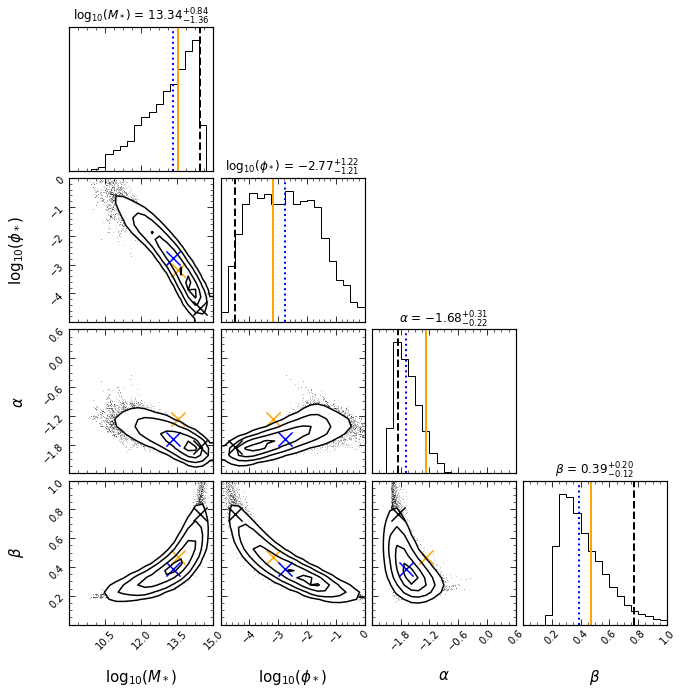

In [46]:
font = {'size'   : 10}
plt.rc('font', **font)
figure = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,
                    smooth=1,hist_bin_factor=1,plot_density=False,
                    data_kwargs=data_kwargs,range=([9,15],[-5,0],[-2.4,0.6],[0,1]),
                      label_kwargs=label_kwargs)
ndim=4
axes = np.array(figure.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(driver_params[i], color="orange",linewidth=2)
    ax.axvline(lcdm_params[i], color="k",linewidth=2,linestyle='dashed')
    ax.axvline(emcee_params[i], color="blue",linewidth=2,linestyle='dotted')

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(driver_params[xi], driver_params[yi], c="orange",s=200,marker='x')
        ax.scatter(lcdm_params[xi], lcdm_params[yi], c="k",s=200,marker='x')
        ax.scatter(emcee_params[xi], emcee_params[yi], c="blue",s=200,marker='x')


plt.savefig('plots/HMF_corner_mean.jpg',bbox_inches='tight',dpi=200)


#### Returning parameters with highest likelihoods

In [47]:
# Creating a dataframe with all samples from MCMC
df_samples=pd.DataFrame(columns=[['m_star','phi_star','alpha','beta']],index=range(len(samples)))

In [48]:
df_samples['m_star']=samples[:,0]
df_samples['phi_star']=samples[:,1]
df_samples['alpha']=samples[:,2]
df_samples['beta']=samples[:,3]

In [49]:
def chi_squared(params, M, phi_obs, phi_err):
    log10_M_star, log10_phi_star, alpha, beta = params
    phi_model = MRP(M, 10**log10_M_star, 10**log10_phi_star, alpha, beta)
    chi2 = np.sum(((phi_obs - phi_model) / phi_err) ** 2)
    return chi2

In [50]:
likelihood_array=[]
chi2_array=[]

In [51]:
# Finding the likelihood and chi2 for each set of parameters
for i in tqdm(df_samples.index):
    params=(df_samples.loc[i]['m_star'],df_samples.loc[i]['phi_star'],
        df_samples.loc[i]['alpha'],df_samples.loc[i]['beta'])
    likelihood_array.append(log_likelihood(params,Mbin_new, phi_means, err_new))
    chi2_array.append(chi_squared(params,Mbin_new, phi_means, err_new))

  0%|          | 0/17056 [00:00<?, ?it/s]

In [52]:
df_samples['likelihood']=likelihood_array
df_samples['chi2']=chi2_array

In [53]:
M_star_sample=df_samples.loc[df_samples[['likelihood']].idxmax()[0]]['m_star']
phi_star_sample=df_samples.loc[df_samples[['likelihood']].idxmax()[0]]['phi_star']
alpha_sample=df_samples.loc[df_samples[['likelihood']].idxmax()[0]]['alpha']
beta_sample=df_samples.loc[df_samples[['likelihood']].idxmax()[0]]['beta']
reduced_chi_squared=df_samples.loc[df_samples[['likelihood']].idxmax()[0]]['chi2']/(len(Mbin_new)-4)

### Plotting HMF

In [54]:
M_arr=np.logspace(11,16,100)

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


  0%|          | 0/569 [00:00<?, ?it/s]

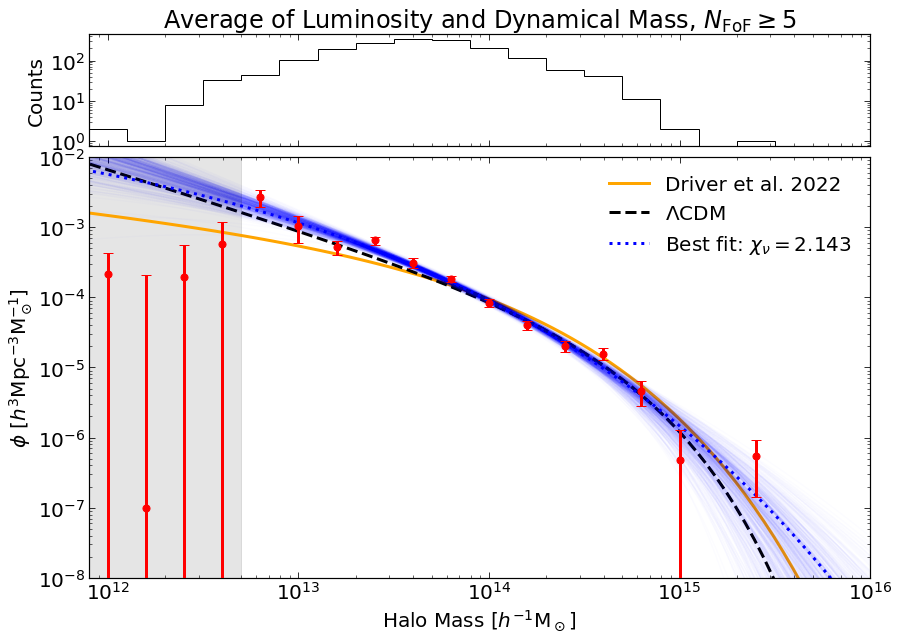

In [58]:
font = {'size'   : 20}
plt.rc('font', **font)

fig, axs = plt.subplots(2,1, facecolor='w', edgecolor='k',
                        gridspec_kw={'height_ratios': [0.8, 3]},figsize=(14,10))
fig.subplots_adjust(hspace = 0.04, wspace=0)
axs=axs.ravel()

Nbin,_=np.histogram(((np.log10(sample['mass_sup']) + np.log10(1.39*sample['MassA']))/2), bins=bins)
edges = []
for M in Mbin:
    edges.append(M + diff/2)
edges.insert(0,edges[0] - diff)
axs[0].stairs(Nbin, 10**np.array(edges),lw=1,color='k')
axs[0].set_xlim(10**11.9,10**16)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Counts')

axs[0].set_title('Average of Luminosity and Dynamical Mass, '+'$N_\mathrm{FoF} \geq 5$')




axs[1].plot((M_arr),(MRP(M_arr,10**13.51,10**-3.19,-1.27,0.47)),
         c='orange',label='Driver et al. 2022',linewidth=3)
axs[1].plot((M_arr),(MRP(M_arr,10**14.43,10**-4.49,-1.85,0.77)),
         c='k',linestyle='dashed',label=r'$\Lambda$'+'CDM',linewidth=3)



axs[1].errorbar((10**Mbin),phi_total_lum*(phi_total_lum/means),yerr=err_tot,
             fmt='none',capsize=5,mfc='none',c='red',linewidth=3,zorder=10)
axs[1].scatter((10**Mbin),phi_total_lum*(phi_total_lum/means),c='red',s=50,zorder=20)

axs[1].plot((M_arr),np.ones(len(M_arr)),
         c='blue')
for i in tqdm(range(len(samples))[::30]):
    phi_fit = MRP(M_arr,10**samples[i][0],10**samples[i][1], samples[i][2],samples[i][3])
    axs[1].plot((M_arr), phi_fit,c='blue',alpha=0.01)
axs[1].plot((M_arr),(MRP(M_arr,10**M_star_sample,10**phi_star_sample,alpha_sample,beta_sample)),
         c='blue',linestyle='dotted',linewidth=3,
         label='Best fit: '+r'$\chi_\nu = $'+str(round(reduced_chi_squared,3)))




axs[1].set_yscale('log')
axs[1].set_xscale('log')


axs[1].legend(frameon=False)

axs[1].axvspan(10**11, 10**12.7 , color='k', alpha=0.1, lw=1)
#plt.axvspan(10**14.5, 10**17 , color='k', alpha=0.1, lw=1)


axs[1].set_xlim(10**11.9,10**16)
axs[1].set_ylim(1e-8,1e-2)
axs[1].set_xlabel('Halo Mass ['+r'$h^{-1}\mathrm{M}_\odot$]')
axs[1].set_ylabel(r'$\phi$' +' ['+r'$h^{3}\mathrm{Mpc}^{-3}\mathrm{M}^{-1}_\odot$]')

plt.savefig('plots/HMF_mean.jpg',bbox_inches='tight',dpi=200)



plt.show()